# Сегментация изображений

In [1]:
!pip install segmentation_models_pytorch

     |████████████████████████████████| 71kB 3.3MB/s 
     |████████████████████████████████| 61kB 9.0MB/s 
     |████████████████████████████████| 245kB 38.9MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-cp37-none-any.whl size=12420 sha256=db8f52a248728d9ec23e0010c837468d15d62c339e45b571898f09ef03dfd7bd
  Stored in directory: /root/.cache/pip/wheels/42/1e/a9/2a578ba9ad04e776e80bf0f70d8a7f4c29ec0718b92d8f6ccd
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp37-none-any.whl size=60966 sha256=5c6640d4621efc752b14a95772458929d809a2ee43a47adce59ec31a92f86a13
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
Successfully built efficientnet-pytorch pretrainedmodels


In [195]:
import os
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [4]:
dst_path = '/content/drive/MyDrive/archive.zip'

In [5]:
from zipfile import ZipFile
zipfile1 = ZipFile(dst_path)
zipfile1.extractall('/content/drive/MyDrive')

### Подготовка датасета

In [204]:
np.unique(plt.imread('/content/drive/MyDrive/set-lipstick-original/mask/mask00007777.png')[:,:,0]*255)

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        90.,  92.,  94.,  95.,  96., 101., 105.], dtype=float32)

In [205]:
df = pd.read_csv('/content/drive/MyDrive/set-lipstick-original/list.csv')
df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,mask
0,image00000001.jpg,1280,720,Lips,661,394,776,444,mask00000001.png
1,image00000002.jpg,1280,720,Lips,557,336,682,392,mask00000002.png
2,image00000003.jpg,1280,720,Lips,553,369,684,427,mask00000003.png
3,image00000004.jpg,1280,720,Lips,555,351,681,408,mask00000004.png
4,image00000005.jpg,1280,720,Lips,555,351,680,407,mask00000005.png


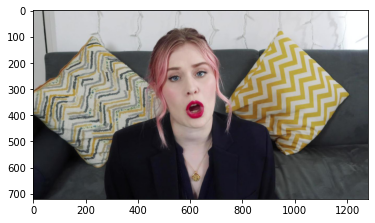

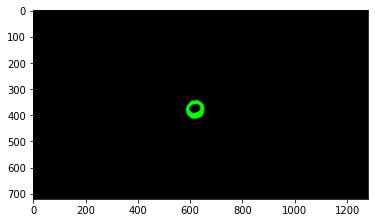

In [206]:
img = plt.imread('/content/drive/MyDrive/set-lipstick-original/720p/image00007777.jpg')
plt.imshow(img)
plt.show()
mask = plt.imread('/content/drive/MyDrive/set-lipstick-original/mask/mask00007777.png')
plt.imshow(mask)
plt.show()

In [207]:
labels = ['nolipsstick','lipstick']

Теперь приведем наш датасет к удобному виду, для этого сначала разделим все на два списка

In [208]:
path_img = "/content/drive/MyDrive/set-lipstick-original/720p"
path_mask = "/content/drive/MyDrive/set-lipstick-original/mask"

images = []
masks = []

for root, dirs, files in os.walk(path_img):
    for name in files:
        f = os.path.join(root, name)
        if 'image' in f:
            images.append(f)
        else:
            break

for root, dirs, files in os.walk(path_mask):
    for name in files:
        f = os.path.join(root, name)
        if 'mask' in f:
            masks.append(f)
        else:
            break

In [209]:
len(images), len(masks), images[-1], masks[-1]

(28594,
 28540,
 '/content/drive/MyDrive/set-lipstick-original/720p/image00028594.jpg',
 '/content/drive/MyDrive/set-lipstick-original/mask/mask00028594.png')

In [210]:
images[0], images[0][-12:-4]

('/content/drive/MyDrive/set-lipstick-original/720p/image00000001.jpg',
 '00000001')

Так как у нас разное количество картинок, убирем лишние

In [211]:
images_w_mask = []

for img in images:
    for mask in masks:
        if img[-12:-4] == mask[-12:-4]:
            images_w_mask.append(img)
            break

In [212]:
len(images_w_mask), images_w_mask[5000], masks[5000]

(28540,
 '/content/drive/MyDrive/set-lipstick-original/720p/image00005001.jpg',
 '/content/drive/MyDrive/set-lipstick-original/mask/mask00005001.png')

In [213]:
masks_adapt = []

for img in images_w_mask:
    masks_adapt.append(f"/content/drive/MyDrive/set-lipstick-original/mask/mask{img[-12:-4]}.png")

In [214]:
images_w_mask[5000], masks_adapt[5000]

('/content/drive/MyDrive/set-lipstick-original/720p/image00005001.jpg',
 '/content/drive/MyDrive/set-lipstick-original/mask/mask00005001.png')

Теперь завернем эти два списка в DataFrame из библиотеки pandas. В итоге выведем первые пять записей из получившегося датафрейма:

In [215]:
df = pd.DataFrame({'images': images_w_mask, 'masks': masks_adapt})
# Отсортируем  датафрейм по значениям
df.sort_values(by='images',inplace=True)
# Используем функцию,
# лагодаря которой индексация значений 
# будет начинаться с 0.
df.reset_index(drop=True, inplace=True)

# Выведем первые пять значений нашего датафрейма
pd.set_option('display.max_colwidth', 70)
print(df.head(5))

                                                                images                                                               masks
0  /content/drive/MyDrive/set-lipstick-original/720p/image00000001.jpg  /content/drive/MyDrive/set-lipstick-original/mask/mask00000001.png
1  /content/drive/MyDrive/set-lipstick-original/720p/image00000002.jpg  /content/drive/MyDrive/set-lipstick-original/mask/mask00000002.png
2  /content/drive/MyDrive/set-lipstick-original/720p/image00000003.jpg  /content/drive/MyDrive/set-lipstick-original/mask/mask00000003.png
3  /content/drive/MyDrive/set-lipstick-original/720p/image00000004.jpg  /content/drive/MyDrive/set-lipstick-original/mask/mask00000004.png
4  /content/drive/MyDrive/set-lipstick-original/720p/image00000005.jpg  /content/drive/MyDrive/set-lipstick-original/mask/mask00000005.png


In [216]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28540 entries, 0 to 28539
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   images  28540 non-null  object
 1   masks   28540 non-null  object
dtypes: object(2)
memory usage: 446.1+ KB


Будем работать с меньшим количеством фотографий для экономии времени

In [217]:
nums = 1000
df = pd.DataFrame({'images': images_w_mask[:nums], 'masks': masks_adapt[:nums]})

In [218]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   images  1000 non-null   object
 1   masks   1000 non-null   object
dtypes: object(2)
memory usage: 15.8+ KB


In [219]:
img = np.asarray(Image.open(images_w_mask[0])).astype('float')
img.shape

(720, 1280, 3)

In [220]:
img = torch.as_tensor(img)/255
img = img.unsqueeze(0)
print(img.shape)
img = img.permute(0,3,1,2)
print(img.shape)
img = F.interpolate(input=img, size=256, align_corners=False, mode='bicubic')
print(img.shape)

torch.Size([1, 720, 1280, 3])
torch.Size([1, 3, 720, 1280])
torch.Size([1, 3, 256, 256])


In [221]:
mask_it = np.asarray(Image.open(masks_adapt[-1])).astype('int')
mask_it.shape

(720, 1280, 3)

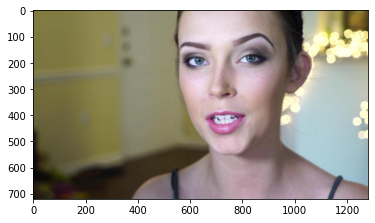

In [222]:
plt.imshow(Image.open(images_w_mask[-1]))

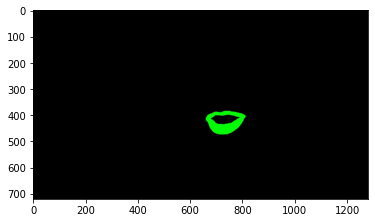

In [223]:
plt.imshow(mask_it)

In [225]:
min(mask_it[mask_it>0]), max(mask_it[mask_it>0]), np.mean(mask_it[mask_it>0])

(1, 255, 83.65212910672328)

In [226]:
mask_it[mask_it[:, :, 1]>0]

array([[0, 1, 4],
       [0, 1, 2],
       [0, 1, 4],
       ...,
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0]])

In [227]:
lab = np.asarray(plt.imread(masks_adapt[-1]))[:,:,1] #.astype('int')
lab.shape

(720, 1280)

In [228]:
min(lab[lab>0]), max(lab[lab>0]), np.mean(lab[lab>0])

(0.003921569, 1.0, 0.6849324)

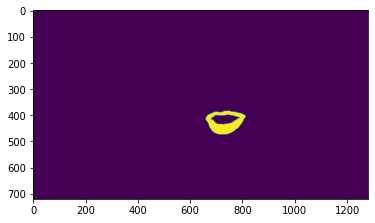

In [229]:
lab[lab>0.4] = 255
plt.imshow(lab)

In [230]:
lab_2 = np.asarray(Image.open(masks_adapt[-1]))[:,:,1]
lab_2.shape

(720, 1280)

In [231]:
min(lab_2[lab_2>0]), max(lab_2[lab_2>0]), np.mean(lab_2[lab_2>0])

(1, 255, 174.65775201047316)

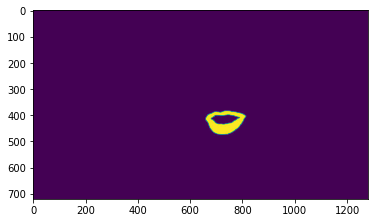

In [232]:
plt.imshow(lab_2)

In [233]:
lab = np.asarray(plt.imread(masks_adapt[-1]))[:,:,1] #.astype('int')
lab.shape

(720, 1280)

In [234]:
lab[lab<0.4] = 0
lab[lab>=0.4] = 1

In [235]:
min(lab[lab>0]), max(lab[lab>0]), np.mean(lab[lab>0])

(1.0, 1.0, 1.0)

In [236]:
lab = torch.as_tensor(lab)
print(lab.shape)
lab = lab.unsqueeze(0).unsqueeze(0)
print(lab.shape)
lab = F.interpolate(input=lab, size=256, mode='nearest')
print(lab.shape)

torch.Size([720, 1280])
torch.Size([1, 1, 720, 1280])
torch.Size([1, 1, 256, 256])


In [237]:
lab = np.asarray(plt.imread(masks_adapt[-1]))[:,:,1]

f_lp = np.where(lab<0.4, 255, 0)
t_lp = np.where(lab>=0.4, 255, 0)

f_lp.shape, t_lp.shape

((720, 1280), (720, 1280))

In [238]:
f_lp[381:476, 657:817]

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]])

In [239]:
lab = np.asarray(plt.imread(masks_adapt[-1]))[:,:,1]

f_lp = torch.as_tensor(np.where(lab<0.4, 255, 0)).unsqueeze(0)
t_lp = torch.as_tensor(np.where(lab>=0.4, 255, 0)).unsqueeze(0)

t_lp = torch.cat((t_lp, f_lp), dim=0).unsqueeze(0)
lab = F.interpolate(input=t_lp.float(), size=256, mode='nearest')
lab.shape

torch.Size([1, 2, 256, 256])

__Теперь обернем все в кастомный датасет для удобной работы в PyTorch.__

In [242]:
class CustomDatasetFromImages(Dataset):
    def __init__(self, data_info):
        # Подаем наш подготовленный датафрейм
        self.data_info = data_info
        
        # Разделяем датафрейм на rgb картинки 
        self.image_arr = self.data_info.iloc[:,0]
        # и на сегментированные картинки
        self.label_arr = self.data_info.iloc[:,1]
        
        # Количество пар картинка-сегментация
        self.data_len = len(self.data_info.index)

    def __getitem__(self, index):
        # Читаем картинку и сразу же представляем ее в виде numpy-массива 
        # размера 720х1280 float-значний
        img = np.asarray(Image.open(self.image_arr[index])).astype('float')
        # Нормализуем изображение в значениях [0,1]
        img = torch.as_tensor(img)/255    
        # 1) unsqueeze - меняет размерность img c (720, 1280, 3) -> (1, 720, 1280, 3),
        # т.е. оборачивает картинку в батч размером в одну картинку
        # 2) permute - меняет местами измерения , т.е. (1, 720, 1280, 3) -> (1, 3, 720, 1280)
        img = img.unsqueeze(0).permute(0,3,1,2)
        # Мы используем функцию интерполяции для того,
        # чтобы поменять рамерность картинки с 1280х720 на 256х256
        img = F.interpolate(input=img, size=256, align_corners=False, mode='bicubic')
        
        # итаем сегментированную картинку и сразу же представляем ее в виде numpy-массива 
        lab = np.asarray(plt.imread(self.label_arr[index]))[:,:,1]

        f_lp = torch.as_tensor(np.where(lab<0.4, 255, 0)).unsqueeze(0)
        t_lp = torch.as_tensor(np.where(lab>=0.4, 255, 0)).unsqueeze(0)

        t_lp = torch.cat((t_lp, f_lp), dim=0).unsqueeze(0)
        # делаем ресайз картинки на 256х256
        lab = F.interpolate(input=t_lp.float(), size=256, mode='nearest')

        return (img.float(), lab.float())

    def __len__(self):
        return self.data_len

In [243]:
from sklearn.model_selection import train_test_split

# 70 % в тренировочную выборку, 30 - в тестовую
X_data, X_test = train_test_split(df, test_size=0.3)
# 30 - в валидационную
X_train, X_valid = train_test_split(X_data, test_size=0.3)

# Упорядочиваем индексацию
X_train.reset_index(drop=True,inplace=True)
X_valid.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)

# Оборачиваем каждую выборку в наш кастомный датасет
train_data = CustomDatasetFromImages(X_train[:30])
valid_data = CustomDatasetFromImages(X_valid[:30])
test_data = CustomDatasetFromImages(X_test)

In [244]:
batch_s = 3

train_data_loader = DataLoader(train_data, batch_size=batch_s, shuffle=True)
valid_data_loader = DataLoader(valid_data, batch_size=batch_s, shuffle=True)
test_data_loader = DataLoader(test_data, batch_size=1, shuffle=False)

Оценим что у нас получилось

In [245]:
sample = iter(train_data_loader).next()

In [246]:
sample[0].size()

torch.Size([3, 1, 3, 256, 256])

In [247]:
sample[1].size()

torch.Size([3, 1, 2, 256, 256])

In [248]:
np.unique(sample[1])

array([  0., 255.], dtype=float32)

### Обучим Модель на выбор из segmentation_models_pytorch

In [249]:
import segmentation_models_pytorch as smp
import time

Определим скорость обучения и количество эпох:

In [250]:
learning_rate = 0.001
epochs = 5

Определим нашу модель Unet

In [251]:
segmodel = smp.Unet('resnet34', classes=2, activation='softmax').to(device)

Под обучением мы понимаем скармливание целевой функции оптимизирующей функции. Поэтому выберем оптимизирующую функцию и функцию потерь (целевая функция):

In [252]:
optimizer = torch.optim.Adam(segmodel.parameters())

In [253]:
class SoftDiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(SoftDiceLoss, self).__init__()

    def forward(self, logits, targets):
        smooth =1
        num = targets.size(0)
        probs = logits
        m1 = probs.view(num, -1)
        m2 = targets.view(num, -1)
        intersection = (m1 * m2)

        score =(2. * intersection.sum(1) + smooth) / (m1.sum(1) + m2.sum(1) + smooth)
        #print(score.sum())
        score =1 - score.sum() / num
        return score
    # This function has only a single output, so it gets only one gradient
    def backward(self, grad_output):

        input, target = self.saved_variables
        grad_input = grad_target = None

        if self.needs_input_grad[0]:
            grad_input = grad_output * 2 * (target * self.union - self.inter) \
                         / (self.union * self.union)
        if self.needs_input_grad[1]:
            grad_target = None

        return grad_input, grad_target

In [254]:
criterion = SoftDiceLoss()

In [255]:
path_checkpoint = "checkpoints_lp"
if not os.path.exists(path_checkpoint):
    os.mkdir(path_checkpoint)

Запускаем сам процесс обучения:

In [256]:
epoch_losses = []
epoch_val_losses = []

for epoch in range(epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    cum_loss = []

    print(f'Epoch: {epoch+1}')
    time1 = time.time()
    segmodel.train()
    for i, data in enumerate(train_data_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device) # .cuda()
        labels = labels.to(device) # .cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = segmodel(inputs[0])
        loss = criterion(outputs, labels[0,:,:,:])
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        cum_loss.append(loss.item())
        if not (i+1) % 10:    # print every 10 mini-batches
            print(f'\tbatchcount: {i+1}, avg. loss for last {batch_s*10} images: {running_loss/(batch_s*10):.5f}')
            running_loss = 0.0

    time2 = time.time()
    epoch_losses.append(np.mean(cum_loss))
    torch.save(segmodel.state_dict(), path_checkpoint + f"/checkpoint_lp_ep_{epoch+1}.pth")

    cum_loss = []
    segmodel.eval()
    with torch.no_grad():
        running_val_loss = 0.0
        for i, data in enumerate(valid_data_loader, 0):
            inputs, labels = data
            inputs = inputs.to(device) # .cuda()
            labels = labels.to(device) # .cuda()

            outputs = segmodel(inputs[0])
            loss = criterion(outputs, labels[0,:,:,:])

            running_val_loss += loss.item()
            cum_loss.append(loss.item())

    epoch_val_losses.append(np.mean(cum_loss))
    print(f'\n  Epoch {epoch+1}, loss: {epoch_losses[-1]:.5f} loss_val: {epoch_val_losses[-1]:.5f} time = {time2-time1:.2f} sec\n')

Epoch: 1


/usr/local/lib/python3.7/dist-packages/segmentation_models_pytorch/base/modules.py:102: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


	batchcount: 10, avg. loss for last 30 images: 0.01131

  Epoch 1, loss: 0.03394 loss_val: 0.63313 time = 2.96 sec

Epoch: 2
	batchcount: 10, avg. loss for last 30 images: -0.12674

  Epoch 2, loss: -0.38021 loss_val: -0.56128 time = 3.24 sec

Epoch: 3
	batchcount: 10, avg. loss for last 30 images: -0.22955

  Epoch 3, loss: -0.68866 loss_val: -0.83026 time = 2.93 sec

Epoch: 4
	batchcount: 10, avg. loss for last 30 images: -0.28337

  Epoch 4, loss: -0.85010 loss_val: -0.86423 time = 2.94 sec

Epoch: 5
	batchcount: 10, avg. loss for last 30 images: -0.30562

  Epoch 5, loss: -0.91685 loss_val: -0.91942 time = 2.88 sec



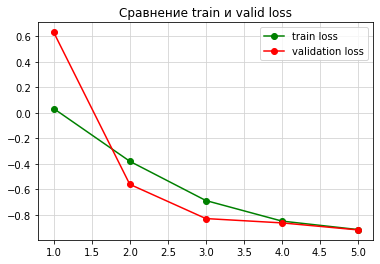

In [257]:
plt.plot(np.arange(1, 6), epoch_losses, 'go-', label='train loss')
plt.plot(np.arange(1, 6), epoch_val_losses, 'ro-', label='validation loss')

plt.legend(loc="upper right")
plt.grid(color="lightgrey")
plt.title('Сравнение train и valid loss' )
plt.show()

In [258]:
net_out = smp.Unet('resnet34', classes=2, activation='softmax').to(device)
net_out.load_state_dict(torch.load(path_checkpoint + f"/checkpoint_lp_ep_5.pth"))

<All keys matched successfully>

/usr/local/lib/python3.7/dist-packages/segmentation_models_pytorch/base/modules.py:102: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


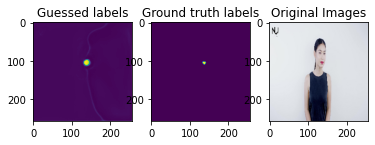

<Figure size 432x288 with 0 Axes>

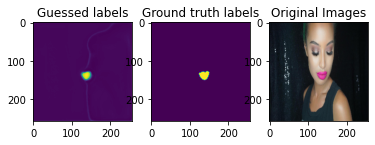

<Figure size 432x288 with 0 Axes>

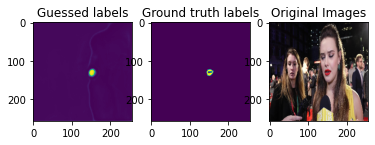

<Figure size 432x288 with 0 Axes>

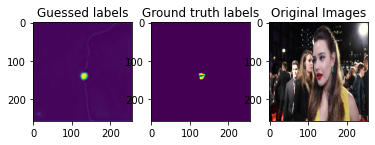

<Figure size 432x288 with 0 Axes>

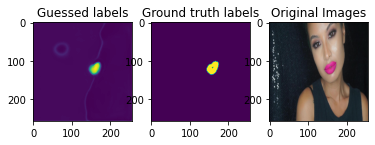

<Figure size 432x288 with 0 Axes>

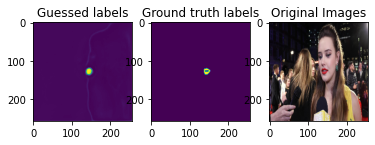

<Figure size 432x288 with 0 Axes>

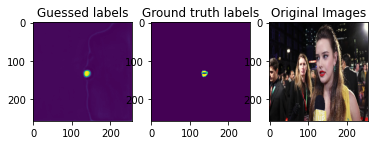

<Figure size 432x288 with 0 Axes>

In [259]:
%matplotlib inline

for i, data in enumerate(valid_data_loader):
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)
    outputs = net_out(images[0])
    f, axarr = plt.subplots(1,3)

    # axarr[0].imshow(torch.argmax(outputs[0].detach().cpu().numpy()[1,:,:]))
    axarr[0].imshow(outputs.squeeze().detach().cpu().numpy()[0,:,:])
    axarr[0].set_title('Guessed labels')
    
    axarr[1].imshow(labels[0].detach().cpu().numpy()[0,0,:,:])
    axarr[1].set_title('Ground truth labels')
    
    original = images[0][0,:,:,:].cpu()
    original = original.permute(1, 2, 0)
    original = original.numpy()
    original = np.clip(original, 0, 1)
    axarr[2].imshow(original)
    axarr[2].set_title('Original Images')
    plt.show()
    plt.gcf().show()
    if i>5:
        break